In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# all states
N_STATES = 19

# all states but terminal states
states = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state values from Bellman equation
realStateValues = np.arange(-20, 22, 2) / 20.0
realStateValues[0] = realStateValues[N_STATES + 1] = 0.0

In [3]:
# base class for lambda-based algorithms in this chapter
# In this example, we use the simplest linear feature function, state aggregation.
# And we use exact 19 groups, so the weights for each group is exact the value for that state
class ValueFunction:
    # @rate: lambda, as it's a keyword in python, so I call it rate
    # @stepSize: alpha, step size for update
    def __init__(self, rate, stepSize):
        self.rate = rate
        self.stepSize = stepSize
        self.weights = np.zeros(N_STATES + 2)

    # the state value is just the weight
    def value(self, state):
        return self.weights[state]

    # feed the algorithm with new observation
    # derived class should override this function
    def learn(self, state, reward):
        return

    # initialize some variables at the beginning of each episode
    # must be called at the very beginning of each episode
    # derived class should override this function
    def newEpisode(self):
        return

In [4]:
# Off-line lambda-return algorithm
class OffLineLambdaReturn(ValueFunction):
    def __init__(self, rate, stepSize):
        ValueFunction.__init__(self, rate, stepSize)
        # To accelerate learning, set a truncate value for power of lambda
        self.rateTruncate = 1e-3

    def newEpisode(self):
        # initialize the trajectory
        self.trajectory = [START_STATE]
        # only need to track the last reward in one episode, as all others are 0
        self.reward = 0.0

    def learn(self, state, reward):
        # add the new state to the trajectory
        self.trajectory.append(state)
        if state in END_STATES:
            # start off-line learning once the episode ends
            self.reward = reward
            self.T = len(self.trajectory) - 1
            self.offLineLearn()

    # get the n-step return from the given time
    def nStepReturnFromTime(self, n, time):
        # gamma is always 1 and rewards are zero except for the last reward
        # the formula can be simplified
        endTime = min(time + n, self.T)
        returns = self.value(self.trajectory[endTime])
        if endTime == self.T:
            returns += self.reward
        return returns

    # get the lambda-return from the given time
    def lambdaReturnFromTime(self, time):
        returns = 0.0
        lambdaPower = 1
        for n in range(1, self.T - time):
            returns += lambdaPower * self.nStepReturnFromTime(n, time)
            lambdaPower *= self.rate
            if lambdaPower < self.rateTruncate:
                # If the power of lambda has been too small, discard all the following sequences
                break
        returns *= 1 - self.rate
        if lambdaPower >= self.rateTruncate:
            returns += lambdaPower * self.reward
        return returns

    # perform off-line learning at the end of an episode
    def offLineLearn(self):
        for time in range(self.T):
            # update for each state in the trajectory
            state = self.trajectory[time]
            delta = self.lambdaReturnFromTime(time) - self.value(state)
            delta *= self.stepSize
            self.weights[state] += delta

In [5]:
# TD(lambda) algorithm
class TemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, stepSize):
        ValueFunction.__init__(self, rate, stepSize)
        self.newEpisode()

    def newEpisode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.lastState = START_STATE

    def learn(self, state, reward):
        # update the eligibility trace and weights
        self.eligibility *= self.rate
        self.eligibility[self.lastState] += 1
        delta = reward + self.value(state) - self.value(self.lastState)
        delta *= self.stepSize
        self.weights += delta * self.eligibility
        self.lastState = state

In [6]:
# True online TD(lambda) algorithm
class TrueOnlineTemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, stepSize):
        ValueFunction.__init__(self, rate, stepSize)

    def newEpisode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.lastState = START_STATE
        # initialize the old state value
        self.oldStateValue = 0.0

    def learn(self, state, reward):
        # update the eligibility trace and weights
        lastStateValue = self.value(self.lastState)
        stateValue = self.value(state)
        dutch = 1 - self.stepSize * self.rate * self.eligibility[self.lastState]
        self.eligibility *= self.rate
        self.eligibility[self.lastState] += dutch
        delta = reward + stateValue - lastStateValue
        self.weights += self.stepSize * (delta + lastStateValue - self.oldStateValue) * self.eligibility
        self.weights[self.lastState] -= self.stepSize * (lastStateValue - self.oldStateValue)
        self.oldStateValue = stateValue
        self.lastState = state

In [7]:
# 19-state random walk
def randomWalk(valueFunction):
    valueFunction.newEpisode()
    currentState = START_STATE
    while currentState not in END_STATES:
        newState = currentState + np.random.choice([-1, 1])
        if newState == 0:
            reward = -1
        elif newState == N_STATES + 1:
            reward = 1
        else:
            reward = 0
        valueFunction.learn(newState, reward)
        currentState = newState

In [11]:
# general plot framework
# @valueFunctionGenerator: generate an instance of value function
# @runs: specify the number of independent runs
# @lambdas: a series of different lambda values
# @alphas: sequences of step size for each lambda
def figure12(valueFunctionGenerator, runs, lambdas, alphas):
    global figureIndex
    # play for 10 episodes for each run
    episodes = 10
    # track the rms errors
    errors = [np.zeros(len(alphas_)) for alphas_ in alphas]
    for run in range(runs):
        for lambdaIndex, rate in zip(range(len(lambdas)), lambdas):
            for alphaIndex, alpha in zip(range(len(alphas[lambdaIndex])), alphas[lambdaIndex]):
                valueFunction = valueFunctionGenerator(rate, alpha)
                for episode in range(episodes):
                    #print('run:', run, 'lambda:', rate, 'alpha:', alpha, 'episode:', episode)
                    randomWalk(valueFunction)
                    stateValues = [valueFunction.value(state) for state in states]
                    errors[lambdaIndex][alphaIndex] += np.sqrt(np.mean(np.power(stateValues - realStateValues[1: -1], 2)))

    # average over runs and episodes
    for error in errors:
        error /= episodes * runs
    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i], label='lambda = ' + str(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

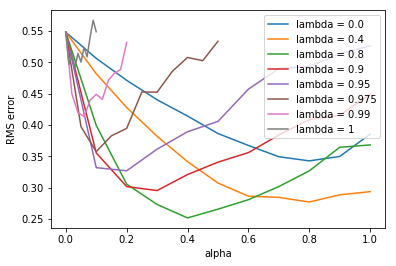

In [12]:
# Figure 12.3: Off-line lambda-return algorithm
def figure12_3():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01)]
    figure12(OffLineLambdaReturn, 50, lambdas, alphas)

figure12_3()

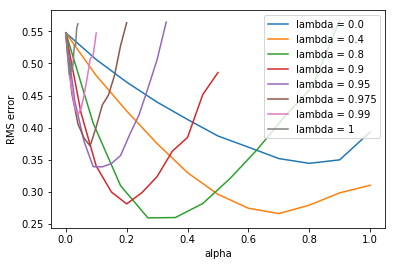

In [13]:
# Figure 12.6: TD(lambda) algorithm
def figure12_6():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]
    figure12(TemporalDifferenceLambda, 50, lambdas, alphas)

figure12_6()

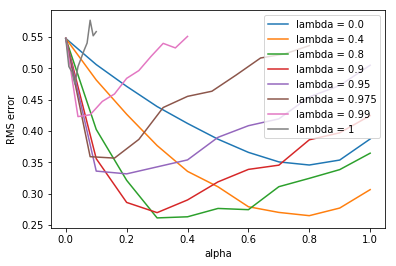

In [14]:
# Figure 12.7: True online TD(lambda) algorithm
def figure12_7():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.88, 0.08),
              np.arange(0, 0.44, 0.04),
              np.arange(0, 0.11, 0.01)]
    figure12(TrueOnlineTemporalDifferenceLambda, 50, lambdas, alphas)

figure12_7()